# **Credits**
Creator: Long Vo <br>
Date: 11/10/2022 <br>
<br>

In [84]:
import warnings
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict

## Load Data

In [85]:
train_ds = np.loadtxt('../assets/training_dataset.txt', dtype=float)
test_ds = np.loadtxt('../assets/test_dataset.txt', dtype=float)

In [86]:
def data_extract(train_data):
    data_list = list()
    label_list = list()
    for val in train_data:
        data_list.append(val[0:784])
        label_list.append(int(val[784]))
    data_list = np.array(data_list)
    label_list = np.array(label_list)
    return data_list, label_list

np.random.shuffle(train_ds)

x_train, y_train = data_extract(train_ds)
x_test, y_test = data_extract(test_ds)
# x_train = x_train / 255

In [87]:
y_train

array([1, 3, 1, ..., 0, 4, 7])

# Neural Network class (Autoencoder)

In [88]:
warnings.filterwarnings('ignore')
EPOCHS = 1000
hidden_neurons = 180

In [89]:
class NeuralNetwork():
    
    def __init__(self, input_nn: int, output_nn: int, hidden_nn: list, hidden_layers: int, learning_rate=0.01, alpha=0.5, epochs=EPOCHS, high=0.75, low=0.25):
        self.input_nn = input_nn
        self.output_nn = output_nn
        self.hidden_nn = hidden_nn
        self.hidden_layers = hidden_layers
        self.learning_rate = learning_rate
        self.alpha = alpha
        self.epochs = epochs
        self.high = high
        self.low = low
        self.b = 1
        self.y_hat = OrderedDict()
        self.w1 = np.random.randn(self.hidden_nn[0], self.input_nn) * np.sqrt(1 / (self.input_nn + self.hidden_nn[0]))
        if hidden_layers < 2:
            self.w2 = np.random.randn(self.output_nn, self.hidden_nn[0]) * np.sqrt(1 / (self.output_nn + self.hidden_nn[0]))
        else:
            self.w_dict = dict()
            for i in range(self.hidden_layers):
                temp = 'w' + str(i + 2)
                if self.hidden_layers - i == 1:
                    self.w_dict[temp] = np.random.rand(self.output_nn, self.hidden_nn[i]) * np.sqrt(1 / (self.output_nn + self.hidden_nn[i]))
                    break
                self.w_dict[temp] = np.random.rand(self.hidden_nn[i + 1], self.hidden_nn[i]) * np.sqrt(1 / (self.hidden_nn[i + 1] + self.hidden_nn[i]))
    
        
    def get_weight(self):
        if self.hidden_layers >= 2:
            return self.w1, self.w_dict
        return self.w1, self.w2
    
    
    def sigmoid(self, x): 
        return 1.0/(1.0 + np.exp(-x))


    def deri_sigmoid(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    
    def forward_prop(self, input_ds):
        self.s1 = np.dot(input_ds, self.w1.T) + self.b
        self.y_hat1 = self.sigmoid(self.s1)
        if self.hidden_layers < 2:
            self.s2 = np.dot(self.y_hat1, self.w2.T) + self.b # net input 
            self.y_hat2 = self.sigmoid(self.s2) # activation function for the output layer.
        else:
            self.s2 = np.dot(self.y_hat1, self.w_dict['w2'].T) + self.b # net input 
            self.y_hat['y_hat2'] = self.sigmoid(self.s2)
            for i in range(1, self.hidden_layers):
                temp_y = 'y_hat' + str(i + 1)
                temp_w = 'w' + str(i + 2)
                s = np.dot(self.y_hat[temp_y], self.w_dict[temp_w].T) + self.b
                temp_y = 'y_hat' + str(i + 2)
                self.y_hat[temp_y] = self.sigmoid(s)
                

    def get_output(self):
        if self.hidden_layers < 2:
            return self.y_hat2
        else:
            self.y_hat_val = list(self.y_hat.items())
            self.y_hat_value = np.array(list(self.y_hat_val[len(self.y_hat_val) - 1]))
            return np.asarray(self.y_hat_value[1])            
        
        
    def backward_prop(self, x, epochs):
          
        if self.hidden_layers < 2:
            self.theta(self.y_hat2)
            self.output_errors = x - self.y_hat2
            
            self.d_output = self.output_errors * self.deri_sigmoid(self.y_hat2)
            # print(self.d_output.shape)
            # print(self.w2.shape)
            # print(self.y_hat1.shape)
            # temp = np.dot(self.d_output, self.w2)
            # print(temp.shape)
            self.d_hidden = self.deri_sigmoid(self.y_hat1) * np.dot(self.d_output, self.w2)
            # print(self.y_hat1.shape)
            delta_w_2 = self.learning_rate * np.dot(np.transpose(self.y_hat1), self.d_output)             
            delta_w_1 = self.learning_rate * np.dot(np.transpose(x), self.d_hidden)

            
            if (epochs > 1): 
                delta_w_2 += (self.alpha * self.pre_delta_w_2) 
                delta_w_1 += (self.alpha * self.pre_delta_w_1)
                self.w2 += delta_w_2.T 
                self.w1 += delta_w_1.T 
            
            self.pre_delta_w_2 = delta_w_2 # update of weights change
            self.pre_delta_w_1 = delta_w_1 # update of weights change
        
        else:
            w_key = ['w' + str(i + 2) for i in range(self.hidden_layers)]
            self.y_hat_val = list(self.y_hat.items())
            self.y_hat_value = np.array(list(self.y_hat_val[len(self.y_hat_val) - 1]))
            self.y_hat_val = np.array(list(self.y_hat_val))            
            self.theta(self.y_hat_value[1])            
            self.output_errors = x - self.y_hat_value[1]
            index = len(self.y_hat_val) - 1
            
            while (index >= 0):
                self.d_output = self.output_errors * self.deri_sigmoid(self.y_hat_val[index][1])
                self.d_hidden = self.deri_sigmoid(self.y_hat_val[index - 1][1]) * np.dot(self.d_output, self.w_dict[w_key[index]])

                delta_w_2 = self.learning_rate * np.dot(np.transpose(self.y_hat_val[index - 1][1]), self.d_output)
                delta_w_1 = self.learning_rate * np.dot(np.transpose(x), self.d_hidden) 

                if(epochs > 1):
                    delta_w_2 += (self.alpha * self.pre_delta_w_2)
                    delta_w_1 += (self.alpha * self.pre_delta_w_1)
                    self.w_dict[index] += delta_w_2.T 
                    self.w_dict[index] += delta_w_1.T 
                
                self.pre_delta_w_2 = delta_w_2 # update of weights change
                self.pre_delta_w_1 = delta_w_1 # update of weights change
                index -= 1
                self.theta(self.y_hat_val[index-1][1])               
                self.output_errors = self.y_hat_val[index][1] - self.y_hat_val[index-1][1]
        
        
    def theta(self, y_hat): # theta for output
        for q in y_hat:
            for idx, j in enumerate(q):
                if j >= self.high:
                    q[idx] = 1.0
                elif j <= self.low:
                    q[idx] = 0.0

# Train Autoencoder

In [90]:
def error_loss(y, yhat):
    ERRORS = 0
    for idx, x in enumerate(y):
        ERRORS += (0.5 * np.sum(((x - yhat[idx])**2)))
    return ERRORS / 784

In [91]:
nn = NeuralNetwork(784, 784, [hidden_neurons], 1)
nn.forward_prop(x_train)
training_errors = list()

In [92]:
nn.get_output().shape

(4000, 784)

In [93]:
for i in range(EPOCHS + 1):
    nn.forward_prop(x_train)
    if i % 10 == 0:
        print(f'Iteration {i}:')
        temp_output = error_loss(x_train, nn.get_output())
        training_errors.append(temp_output)
        print(f'Error fraction: {temp_output}')
    nn.backward_prop(x_train, i)

Iteration 0:
Error fraction: 912.7496449608689
Iteration 10:
Error fraction: 316.1598586312857
Iteration 20:
Error fraction: 312.777395733557
Iteration 30:
Error fraction: 296.59069562675035
Iteration 40:
Error fraction: 355.52132755014077
Iteration 50:
Error fraction: 212.08333172073293
Iteration 60:
Error fraction: 188.98002416896415
Iteration 70:
Error fraction: 143.64429637206797
Iteration 80:
Error fraction: 130.86963171327056
Iteration 90:
Error fraction: 111.59166990287669
Iteration 100:
Error fraction: 108.212900573313
Iteration 110:
Error fraction: 109.12099452773747
Iteration 120:
Error fraction: 99.89339210486888
Iteration 130:
Error fraction: 102.46052492955994
Iteration 140:
Error fraction: 101.17307309559317
Iteration 150:
Error fraction: 103.22488952690642
Iteration 160:
Error fraction: 99.41903525556516
Iteration 170:
Error fraction: 95.74414611228048
Iteration 180:
Error fraction: 100.79716851982862
Iteration 190:
Error fraction: 96.90511634481386
Iteration 200:
Error 

### Display for testing purpose

<AxesSubplot: >

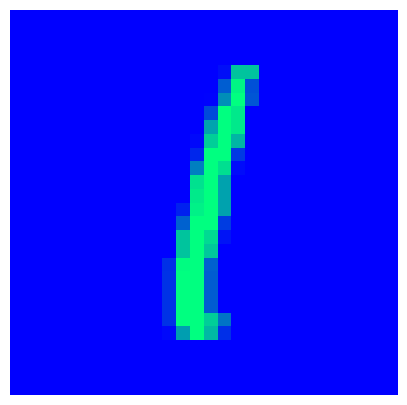

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
sns.heatmap(x_train[2399].reshape(28, 28).T, ax=ax, vmin=0, vmax=1, cmap='winter', xticklabels=False, yticklabels=False, cbar=False)

<AxesSubplot: >

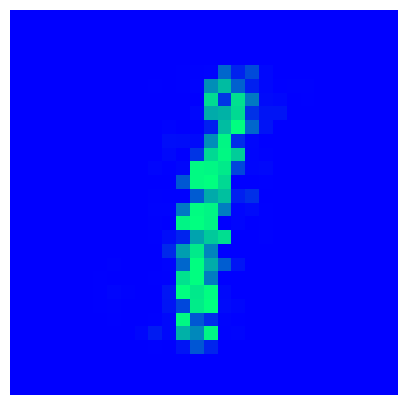

In [95]:
nn.forward_prop(x_train)
fig, ax = plt.subplots(1, 1, figsize=(5,5))
sns.heatmap(nn.get_output()[2399].reshape(28, 28).T, ax=ax, vmin=0, vmax=1, cmap='winter', xticklabels=False, yticklabels=False, cbar=False)

# Sample Output

In [96]:
def get_random_list(limit, num):
    random_list = list()
    iteration = 0
    while iteration < limit:
        r = random.randint(0, num - 1)
        if r not in random_list:
            random_list.append(r)
            iteration += 1
    return random_list


def get_index_digit(digit, data):
    index = list()
    for i, value in enumerate(data):
        if value == digit:
            index.append(i)
    return index


def get_error_digit(y, yhat, digits):
    ERRORS = 0
    for digit in digits:
        ERRORS += (0.5 * np.sum(((y[digit] - yhat[digit])**2)))                      
    return ERRORS / 784

In [127]:
random_sample = get_random_list(8, hidden_neurons)
print(random_sample)

[153, 175, 12, 29, 118, 173, 94, 139]


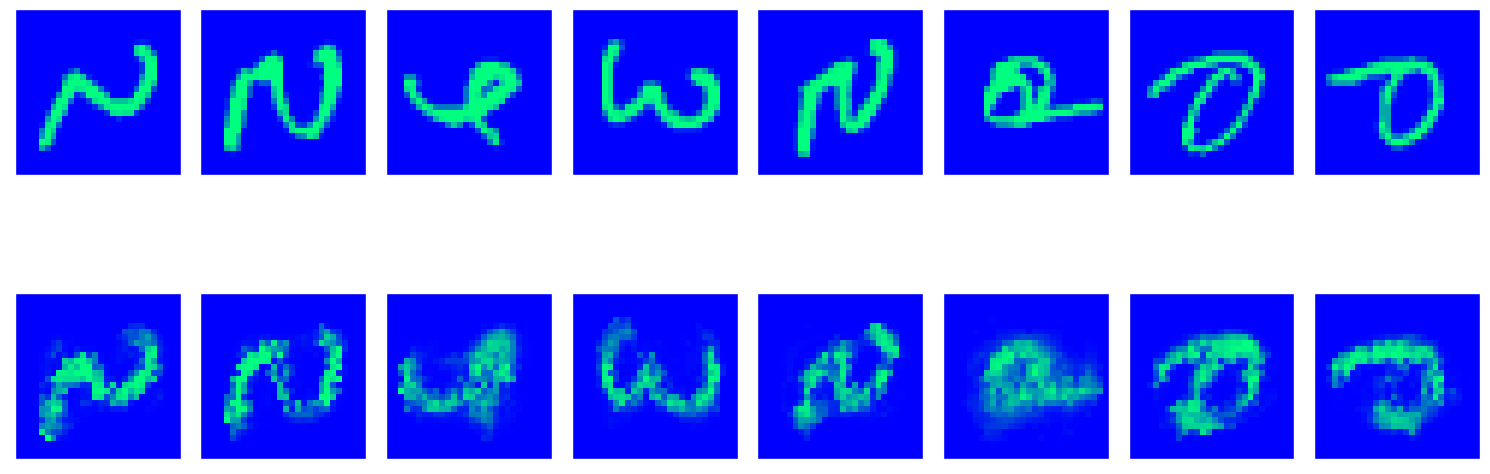

In [133]:
nn.forward_prop(x_test)
output_test = nn.get_output()
fig, ax = plt.subplots(2, 8, figsize=(15, 7))
plt.style.use('ggplot')
for i in range(len(random_sample)):
    ax[0, i].imshow(x_test[random_sample[i]].reshape(28, 28), cmap='winter')
    ax[1, i].imshow(output_test[random_sample[i]].reshape(28, 28), cmap='winter')
    ax[0, i].set_xticks([])
    ax[0, i].set_yticks([])
    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])
   
fig.tight_layout()
fig.savefig('../assets/sample_output.png')

# Features

In [99]:
nn_weight = np.loadtxt('../assets/weight_jk_nn.txt', dtype=float)
print(nn_weight.shape)
nn.forward_prop(x_train)
w1, w2 = nn.get_weight()
print(w1.shape)

(180, 784)
(180, 784)


In [100]:
w1

array([[-0.02276791, -0.04516552, -0.00263822, ..., -0.00620265,
        -0.00067665, -0.01480049],
       [ 0.07666729, -0.01340957, -0.00260431, ..., -0.03114618,
        -0.03354029,  0.04691457],
       [ 0.01543623, -0.01080227, -0.02606487, ...,  0.00058599,
         0.00827054, -0.04128356],
       ...,
       [-0.03079952, -0.02061378, -0.02363566, ...,  0.07364158,
         0.04758037, -0.03894398],
       [-0.07782008,  0.04392149, -0.0557886 , ..., -0.01400878,
        -0.0014837 , -0.00043382],
       [-0.00775804,  0.01071009,  0.01078789, ..., -0.01238132,
        -0.04191408, -0.06133995]])

In [101]:
train_sample = get_random_list(20, hidden_neurons)
print(train_sample)

[27, 89, 38, 178, 170, 124, 20, 131, 171, 125, 127, 63, 70, 6, 133, 179, 160, 53, 54, 26]


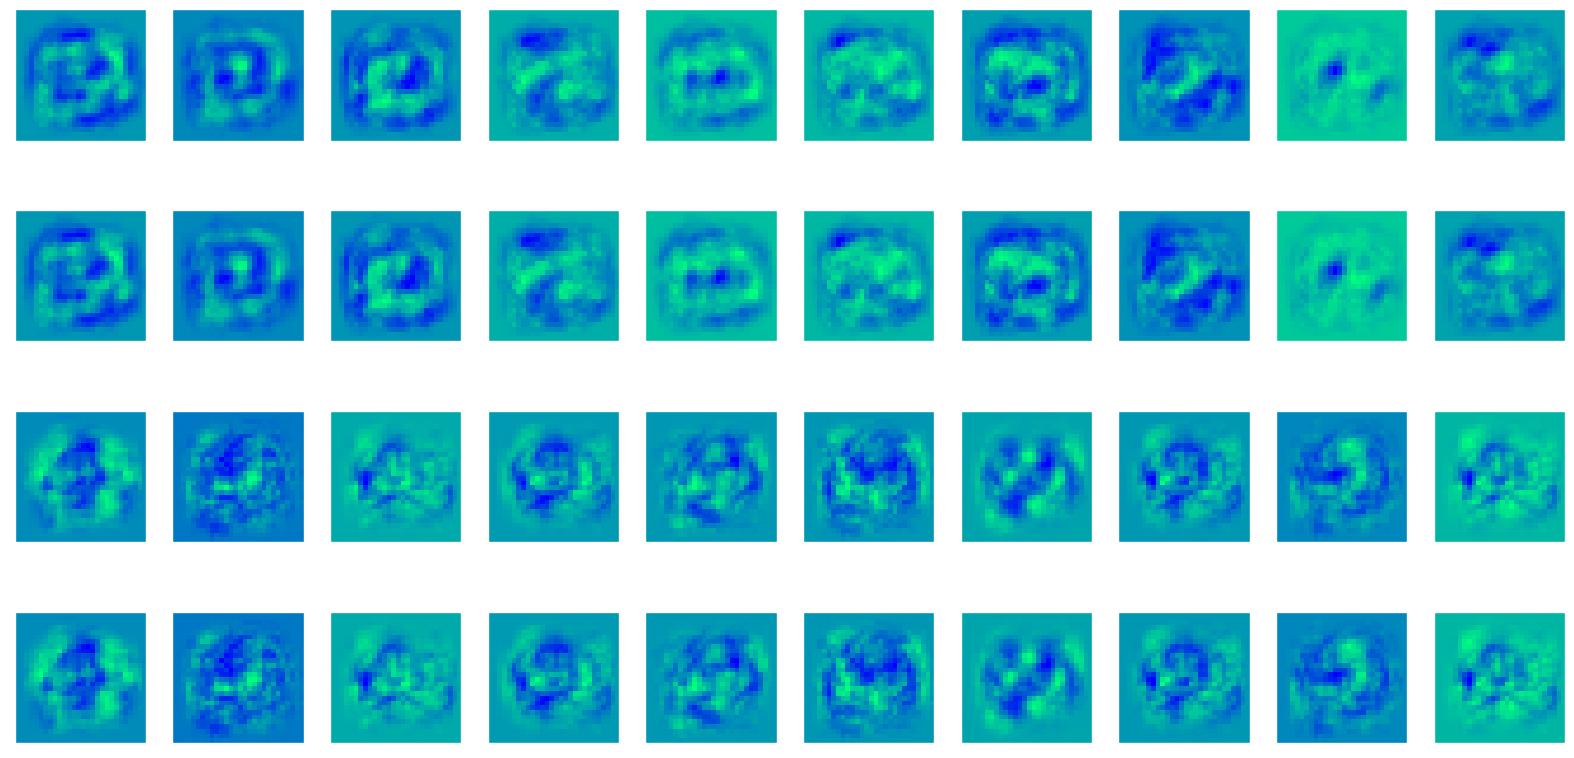

In [132]:
fig, ax = plt.subplots(4, 10, figsize=(20, 10))
for i in range(2):
    for j in range(10):
        ax[i, j].imshow(w1[train_sample[j]].reshape(28, 28), cmap='winter')
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i + 2, j].imshow(nn_weight[train_sample[j]].reshape(28, 28), cmap='winter')
        ax[i + 2, j].set_xticks([])
        ax[i + 2, j].set_yticks([])
fig.savefig('../assets/features.png')

# Result

## Bar Chart of average loss on every digit

In [103]:
def digit_extract(data):
    digits = dict()
    for i in range(10):
        digits[i] = get_index_digit(i, data)
    return digits

In [104]:
train_digits, test_digits = digit_extract(y_train), digit_extract(y_test)

In [105]:
nn.forward_prop(x_train)
train_output = nn.get_output()
nn.forward_prop(x_test)
test_output = nn.get_output()

In [106]:
def get_dataset_error(x, x_out, digits):
    errors = dict()
    for i in range(10):
        errors[i] = get_error_digit(x, x_out, digits[i])
    return errors

In [107]:
ERROR_TRAIN, ERROR_TEST = get_dataset_error(x_train, train_output, train_digits), get_dataset_error(x_test, test_output, test_digits)

In [108]:
ERROR_TEST

{0: 1.75192939916529,
 1: 0.7828098927166034,
 2: 1.9434170822417043,
 3: 1.83302374956901,
 4: 1.6293134480482272,
 5: 1.8456808725529874,
 6: 1.8078430902658826,
 7: 1.6678804038750625,
 8: 2.031598082006559,
 9: 1.6478044474289697}

In [109]:
total_train_error = sum(ERROR_TRAIN.values())
total_test_error = sum(ERROR_TEST.values())

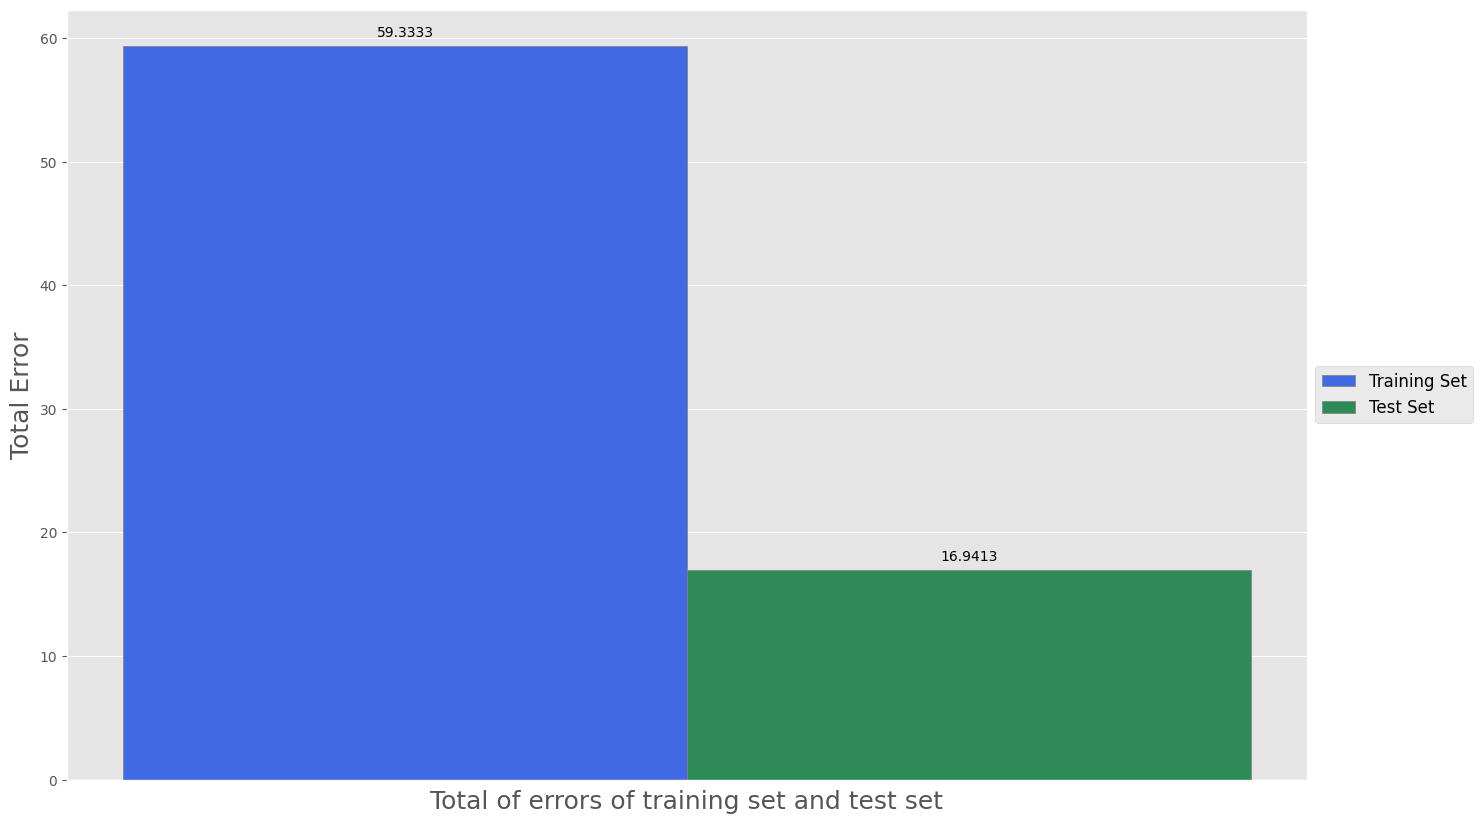

In [131]:
train_set = tuple([total_train_error])
test_set = tuple([total_test_error])


fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
labels = [f'{i}' for i in range(10)]

rect1 = ax.bar(1-0.5, train_set, width=0.5, color='royalblue',label='Training Set', align='edge', edgecolor ='grey')
rect2 = ax.bar(1, test_set, width=0.5, color='seagreen',label='Test Set', align='edge',edgecolor ='grey')

ax.bar_label(rect1, padding=5)
ax.bar_label(rect2, padding=5)
ax.set_xticks([])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 12})
plt.xlabel('Total of errors of training set and test set', fontsize=18)
plt.ylabel('Total Error', fontsize=18)
fig.savefig('../assets/total_loss.png')

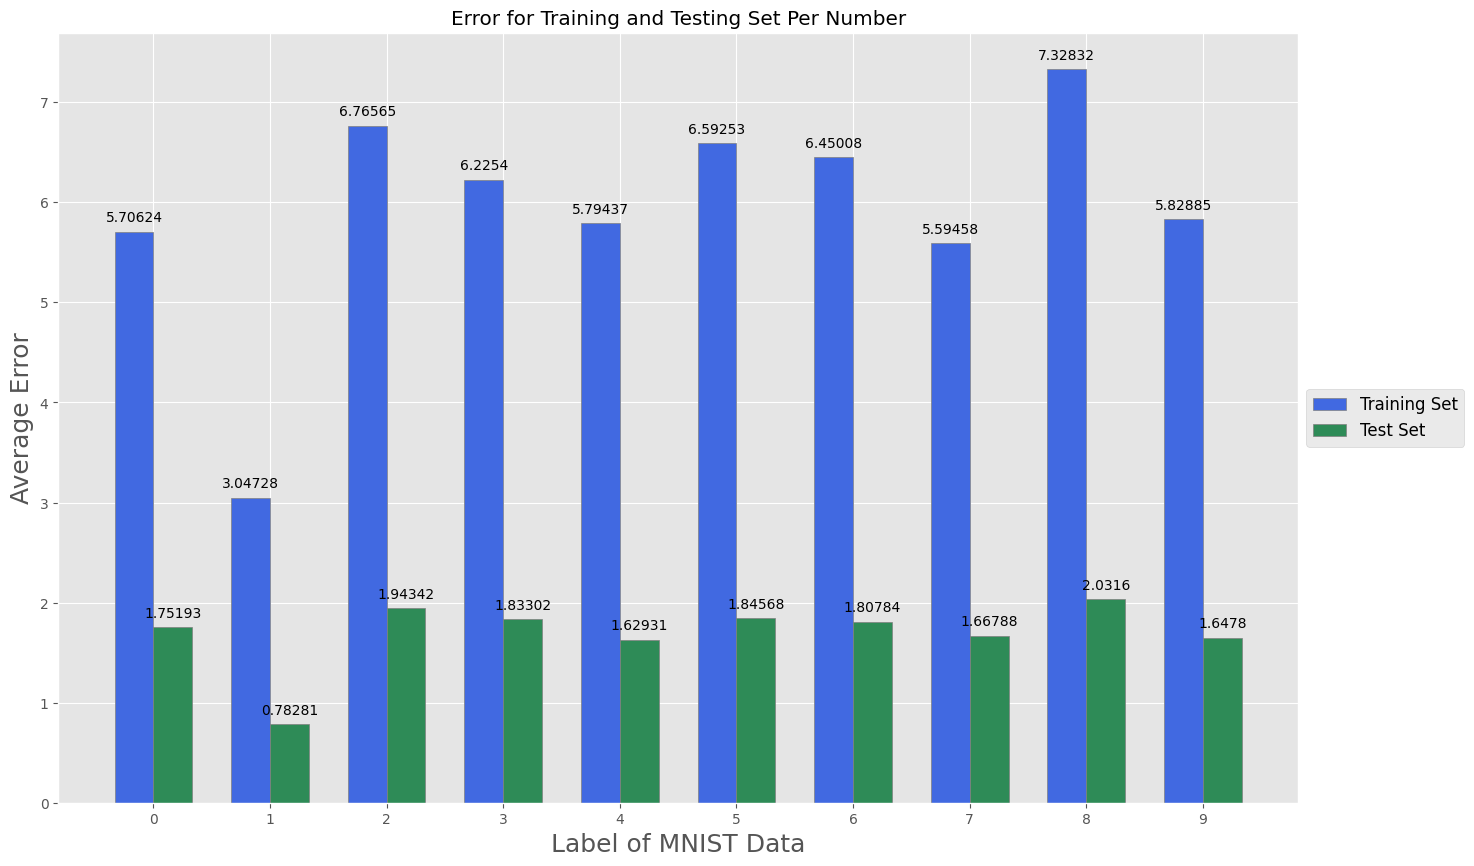

In [130]:
train_set = tuple(ERROR_TRAIN.values())
test_set = tuple(ERROR_TEST.values())
index = list(ERROR_TEST.keys())

width = np.min(np.diff(index)) / 3

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
labels = [f'{i}' for i in range(10)]

rect1 = ax.bar(index - width, train_set, width=width, color='royalblue',label='Training Set', align='edge', edgecolor ='grey')
rect2 = ax.bar(index, test_set, width=width, color='seagreen',label='Test Set', align='edge',edgecolor ='grey')
ax.set_xticks(index, labels)
ax.bar_label(rect1, padding=5)
ax.bar_label(rect2, padding=5)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 12})
plt.xlabel('Label of MNIST Data', fontsize=18)
plt.ylabel('Average Error', fontsize=18)
plt.title('Error for Training and Testing Set Per Number')
fig.savefig('../assets/average_loss.png')

## Time series of training error

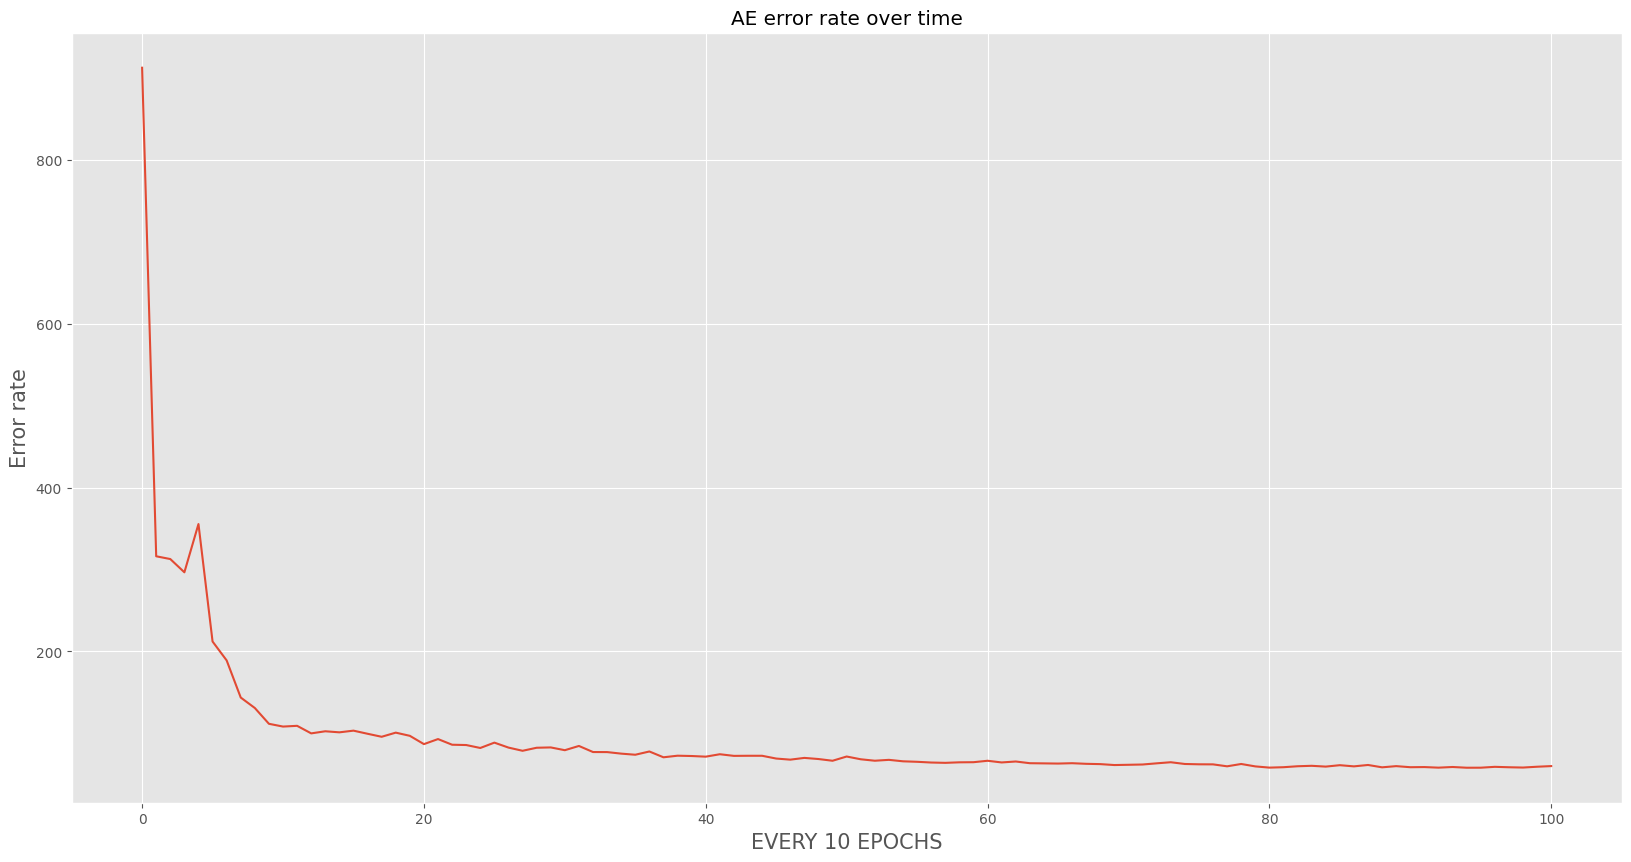

In [129]:
# Time series of error rate overtime
fig = plt.figure(figsize=(20, 10))
plt.plot(training_errors)
plt.title('AE error rate over time')
plt.xlabel('EVERY 10 EPOCHS', fontsize=15)
plt.ylabel('Error rate', fontsize=15)
fig.savefig('../assets/autoencoder_error.png')